# Data Preprocessing and Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# MovieLens 100K

### Rating Data
Movies (i.e., items) can have ratings from users on an integer scale from 1 to 5.

In [8]:
def encode_data(data):
    """
    Integer encode data
    """
    encoder = LabelEncoder()
    for col in data.columns:
        data['{}'.format(col) + '_enc'] = encoder.fit_transform(data['{}'.format(col)])
    return data

In [9]:
def top_n_items(n, ratings):
    """
    Assume "item_id", "rating" column names
    ;param n: top n items to return
    ;param ratings: item ratings
    """
    # get top n items
    top_items = ratings.groupby('item_id')['rating']\
        .count()\
        .sort_values(ascending=False)\
        .index.values[: n]

    # filter data
    return ratings[ratings.item_id.isin(top_items)]

/var/folders/7h/tdfv8d5d6d79_0583_jhq_pm0000gn/T/ipykernel_78729/55065140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['{}'.format(col) + '_enc'] = encoder.fit_transform(data['{}'.format(col)])
/var/folders/7h/tdfv8d5d6d79_0583_jhq_pm0000gn/T/ipykernel_78729/55065140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['{}'.format(col) + '_enc'] = encoder.fit_transform(data['{}'.format(col)])


,user_id,item_id,rating_old,rating,time_bucket
1,185,79,3,0,0
6,114,66,2,0,0
10,61,64,2,0,0
12,199,58,5,1,0
22,298,33,4,1,0


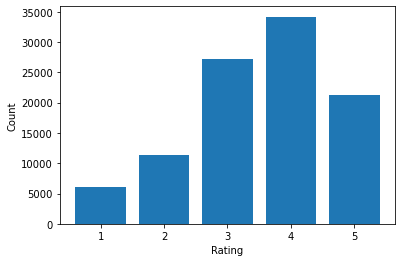

In [10]:
############## import user-item ratings ########################################
ratings = pd.read_csv('data/ml-100k/u.data', delimiter = "\t", header=None)                 # import data
ratings.columns = ["user_id", "item_id", "rating", "timestamp"]                             # add columns

############## plot value count of ratings #####################################
ratings_counts = ratings.rating.value_counts()
plt.bar(ratings_counts.index, ratings_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')

ratings = top_n_items(n=100, ratings=ratings)                                               # select top n items

############## preprocess ratings ################################################
ratings.rename(columns={'rating':'rating_old'}, inplace=True)                               # rename rating column before transformation             
ratings.loc[ratings.rating_old < 4, 'rating'] = 0                                           # transform ratings 4, 5 -> 1, else 0
ratings.loc[ratings.rating_old >= 4, 'rating'] = 1
ratings['rating'] = ratings['rating'].astype(int)                                           # convert rating column to int

############## convert timestamp to time bucket #################################
bins = 5                                                                                    # choose number of time buckets
ratings['time_bucket'] = pd.cut(                                                            # cut timestamps into buckets
    np.arange(len(ratings))
    ,bins=bins
    ,labels=np.arange(bins)
).astype(int)
ratings.drop(columns=['timestamp'], inplace=True)                                           # drop timestamp column

ratings[['user_id', 'item_id']] = encode_data(                                              # encode user, item id
    ratings[['user_id', 'item_id']])[['user_id_enc', 'item_id_enc']]

ratings.to_csv('data/ml-100k/ratings_enc.csv', index=False)                                 # write to csv
ratings.head()

Because we are using the replayer method on the ratings table where we step through the historical log of items sequentially and only tally the ratings of the recommended item if it matches what what seen in the historical data, otherwise we discard it. The consequence is an unbiased estimate of the mean rating or recommended items, but also, the more items we include in our analysis the less likely we are to 'sample' them, and the smaller our sample size. For this reason, we employ a top 'N' item selector as a preprocessing step:

### Item Data
Consists of one-hot encoded genre columns. I convert these back into a single column, where each value is a list of genres. I also convert release data into release year, inpute missing values using the mean. Note that all features are treated as categorical.

In [10]:
def convert_to_list(cols, items):
    """
    Compile list of multiple one-hot columns into single column of lists
    """
    results = []                                                        # initialize empty list
    results_enc = []                                                    # initialize empty list
    n = len(cols)                                                       # vocab size
    dat = items[cols]                                                   # data w relevent columns
    for i in range(items.shape[0]):
        results.append(dat.columns[dat.iloc[i] == 1].tolist())          # string list
        results_enc.append(np.arange(n)[dat.iloc[i] == 1].tolist())     # integer encoded list
    
    return results, results_enc

#### Preprocess Item Data

,item_id,movie_title,genre,genre_enc,release_decade,release_decade_enc
0,0,Toy Story (1995),"[Animation, Children's, Comedy]","[3, 4, 5]",1990,7
1,1,GoldenEye (1995),"[Action, Adventure, Thriller]","[1, 2, 16]",1990,7
2,2,Four Rooms (1995),[Thriller],[16],1990,7
3,3,Get Shorty (1995),"[Action, Comedy, Drama]","[1, 5, 8]",1990,7
4,4,Copycat (1995),"[Crime, Drama, Thriller]","[6, 8, 16]",1990,7


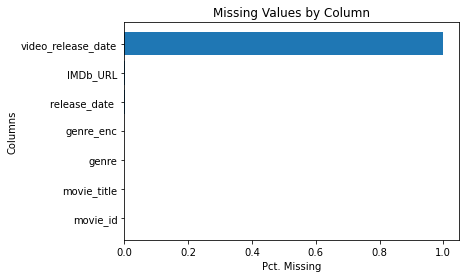

In [11]:
############## import data #############################################
items = pd.read_csv('data/ml-100k/u.item' ,delimiter='|' ,encoding='Latin-1'                        # import data
    ,header=None,engine="python"
    )
items.columns = [
    "movie_id", "movie_title", "release_date ", "video_release_date",                               # add column names
    "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
    "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
    "Thriller", "War", "Western"]


############## preprocess genre ########################################
non_genre_cols = ['movie_id', 'movie_title', 'release_date ', 'video_release_date', 'IMDb_URL']     # not genre ontolgoy cols
genres = [x for x in items.columns if not x in non_genre_cols]                                      # genre onotology cols
items['genre'], items['genre_enc'] = convert_to_list(cols=genres, items=items)                      # genre in single column
items.drop(columns=genres, inplace=True)                                                            # drop one-hot genre columns

############## investigate missing values ##############################
n_missing = items.isna().sum(axis=0).sort_values(ascending=True)                                    # plot pct. missing values 
plt.barh(n_missing.index, n_missing.values/items.shape[0])
plt.title('Missing Values by Column')
plt.xlabel('Pct. Missing')
plt.ylabel('Columns')

############## preprocess release decade ################################
items['release_decade'] = pd.to_datetime(items['release_date ']).dt.year                            # convert to year
items.loc[items.release_decade.isna(), 'release_decade'] = np.mean(items.release_decade)            # impute missing with mean
items['release_decade'] = ((items.release_decade/10).apply(np.floor)*10).astype(int).astype(str)    # convert to string
items['release_decade_enc'] = items.release_decade.rank(method='dense').astype(int) - 1             # add integer encoded column

items.drop(columns=['video_release_date', 'IMDb_URL', 'release_date '], inplace=True)               # drop missing, useless columns
items.rename(columns={'movie_id':'item_id'}, inplace=True)                                          # rename movie_id to item_id
items['item_id'] = items.item_id.rank(method='dense').astype(int) - 1                               # translate item_id 0, 1, ...

items.to_csv('data/ml-100k/items_enc.csv', index=False)                                             # write to csv
items.head()

### User Data

Preprocessing User Data

,gender,occupation,decades_lived,user_id,gender_enc,occupation_enc,decades_lived_enc
0,M,technician,20,0,1,19,2
1,F,other,50,1,0,13,5
2,M,writer,20,2,1,20,2
3,M,technician,20,3,1,19,2
4,F,other,30,4,0,13,3


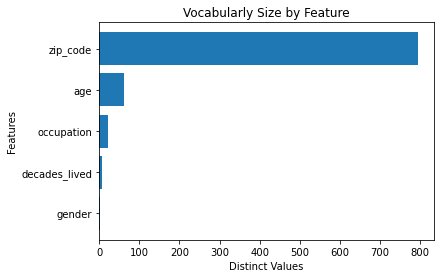

In [137]:
############## import information about the users ############################
users = pd.read_csv('data/ml-100k/u.user', delimiter="|", header=None, engine="python")             # import data
users.columns = ["user_id", "age", "gender", "occupation", "zip_code"]                              # add columns names

############## preprocess user age ###########################################
users['decades_lived'] = ((users.age/10).apply(np.floor)*10)\
    .astype(int).astype(str)                                                                        # round age to nearest decade

############## plot ontology sizes for each feature ##########################
vocab_size = users.drop(columns=['user_id']).nunique().sort_values(ascending=True)                  # plot pct. missing values 
plt.barh(vocab_size.index, vocab_size.values)
plt.title('Vocabularly Size by Feature')
plt.xlabel('Distinct Values')
plt.ylabel('Features')

users.drop(columns=['zip_code', 'age'], inplace=True)                                               # drop large vocab features

############## integer encode features #######################################
users = encode_data(users)                                                                          # add integer encoded oolumns
users.drop(columns=['user_id'], inplace=True)                                                       # drop user_id
users.rename(columns={'user_id_enc':'user_id'}, inplace=True)                                       # rename user_id_enc as user_id

users.to_csv('data/ml-100k/users_enc.csv', index=False)
users.head()

# MovieLens 100K: Bayesian Clustering

In [2]:
user_cols = ['user_id', 'gender_enc', 'decades_lived_enc', 'occupation_enc']
item_cols = ['item_id', 'genre_enc', 'release_decade_enc']

user = pd.read_csv('data/ml-100k/users_enc.csv', usecols=user_cols)
item = pd.read_csv('data/ml-100k/items_enc.csv', usecols=item_cols)

from ast import literal_eval
item['genre_enc'] = item['genre_enc'].apply(lambda x: literal_eval(x))              # convert string list '[]' to list []

In [3]:
from BayesMatch import BayesMatch

n_clusters = 3
match = BayesMatch(
        u_data=user.drop('user_id', axis=1),
        v_data=item.drop('item_id', axis=1),
        n_common=0,
        n_clusters=n_clusters,
        burn_in=0,
        n_samples=10,
        eval_every=100
    )

match.fit()

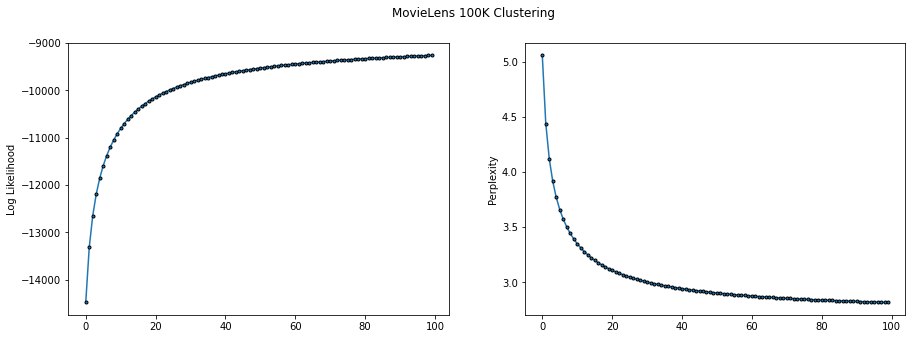

In [83]:
# plot results
burn_in = match.burn_in

# figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot data
ax[0].plot(match.log_likelihood_trace[burn_in:], marker='.', markeredgecolor='black')
ax[1].plot(match.perplexity_trace[burn_in:], marker='.', markeredgecolor='black')

# labels
plt.suptitle('MovieLens 100K Clustering')
ax[0].set_ylabel('Log Likelihood')
ax[1].set_ylabel('Perplexity')

# show
plt.show()

Look at theta MCMC trace.

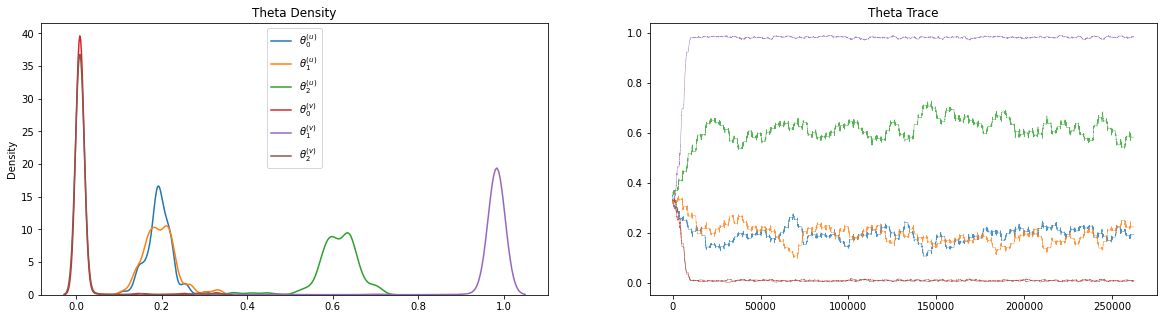

In [84]:
# make figure
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# plot user, item theta
burn_in = match.burn_in
u_theta = [x/sum(x) for x in match.u_theta_trace]
v_theta = [x/sum(x) for x in match.v_theta_trace]

for i, trace in enumerate([u_theta, v_theta]):
    for i in range(n_clusters):
        theta_norm = [x[i] for x in trace[burn_in:]]
        sns.kdeplot(theta_norm, bw_adjust=3, ax=ax[0])

    ax[0].set_title('Theta Density')

    ax[1].plot(trace, lw=0.5, alpha=0.8)
    ax[1].set_title('Theta Trace')

# add legend
legend = []
t = ['{(u)}', '{(v)}']
for l in t:
    legend += ['$\\theta_{}^{}$'.format(i, l) for i in range(n_clusters)]
ax[0].legend(legend)

plt.show()

In [85]:
def plot_item_clusters(k, n):
    """
    ;param k: cluster id
    ;param n: top n most probable items for cluster k
    """
    theta_est = match.get_theta(view=1)                                             # get theta estimate
    cols = ['cluster_{}'.format(i) for i in range(theta_est.shape[1])]              # generate column names for each cluster

    item_cols = ['item_id', 'movie_title', 'genre']                                 # get item id, names
    item_denc = pd.read_csv('data/ml-100k/items_enc.csv', usecols=item_cols)
    item_denc[cols] = match.get_theta(view=1)                                       # get theta estimates
    item_denc['movie_title'] = item_denc['movie_title'] + '-' + item_denc['genre']

    results = item_denc[['movie_title', cols[k]]].sort_values(cols[k], ascending=False)\
        .head(n)

    fig = plt.figure(figsize=(10, 5))
    plt.barh(results.movie_title[::-1], results[cols[k]][::-1], alpha=0.8)           # bar plot
    plt.title('Cluster k = {}'.format(k))

    plt.show()

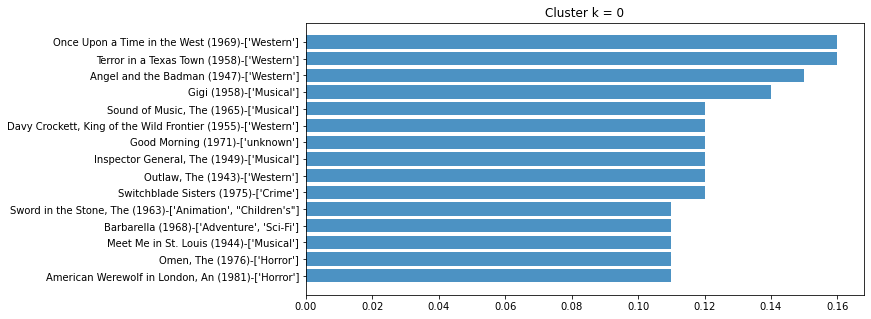

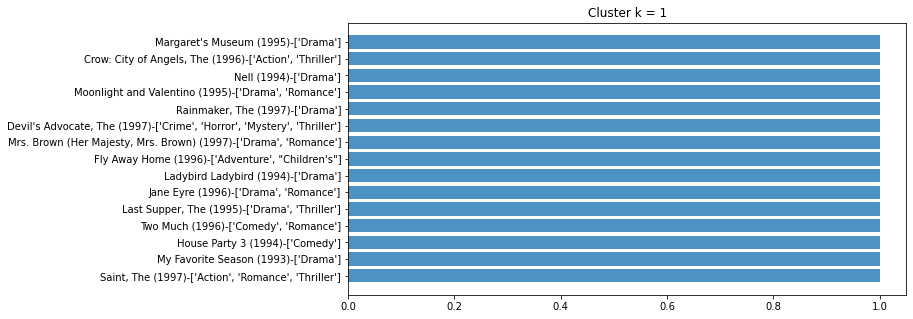

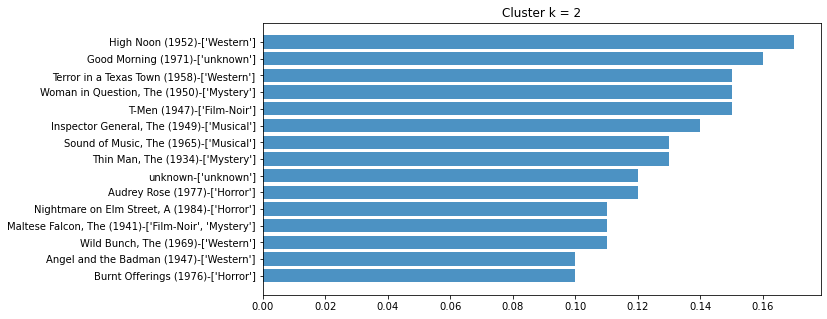

In [86]:
for k in range(match.n_clusters):
    plot_item_clusters(k=k, n=15)

How are feature values being clustered? Does it make sense?

In [188]:
def plot_credible_int(k):
    """
    Plot 80% credible interval
    ;param k: cluster index
    """
    cols_denc = ['gender', 'decades_lived', 'occupation']
    cols_enc = [x + '_enc' for x in cols_denc]
    user_decode = pd.read_csv('data/ml-100k/users_enc.csv', usecols=cols_denc +cols_enc)
    # iterate through features
    df_stack = pd.DataFrame()
    for x in range(len(cols_denc)):
        results = build_dataframe(x, k)
        cols = [cols_denc[x], cols_enc[x]]
        results = results.reset_index().rename(columns={'index':'enc'})
        results = results.merge(user_decode[cols].drop_duplicates(), left_on=results['enc'], right_on=cols[1], how='left')\
            .drop(columns=cols[1])\
            .rename(columns={cols[0]:'feature'})

        results = results.loc[~results.isna().any(axis=1), :]
        df_stack = pd.concat([df_stack, results])
    
    # plot stack
    fig = plt.figure(figsize=(10, 5))
    df_stack = df_stack.sort_values('mean', ascending=True)
    plt.scatter(df_stack['mean'], df_stack['feature'].astype(str), color='black')                   # scatter plot
    plt.hlines(df_stack['feature'].astype(str), df_stack['0.2'], df_stack['0.8'], color='black')    # credible intervals
    plt.barh(df_stack['feature'].astype(str), df_stack['mean'], alpha=0.5, color='blue')            # bar plot

    # add labels
    plt.title('Cluster {}'.format(k))
    plt.xlabel('Probability')
    plt.ylabel('Feature Values')

    plt.show()

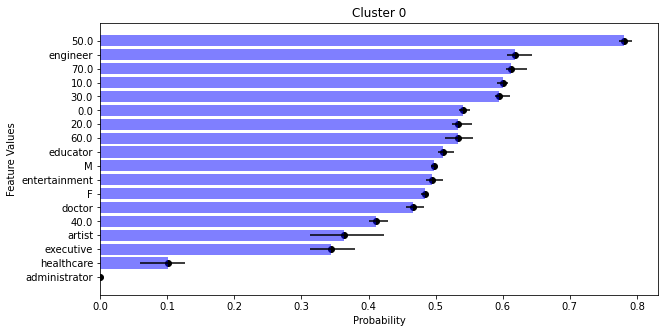

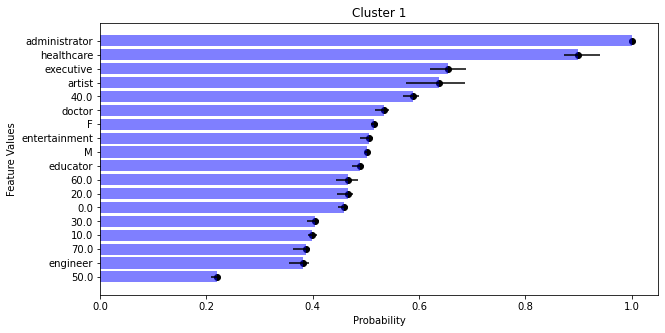

In [195]:
for k in range(match.n_clusters):
    plot_credible_int(k=k)

# MovieLens 1000K: ICTR
Using replayer method, evaluate MovieLens 100K.

In [4]:
from Replayer import Replayer

# get ratings data
ratings = pd.read_csv('data/ml-100k/ratings_enc.csv')
ratings = ratings[['user_id', 'item_id', 'rating', 'time_bucket']]

# get model params from data
T = ratings.time_bucket.nunique()           # get number of unique time buckets
# get number of users, items
n_users = ratings.user_id.nunique()         # number of users
n_items = ratings.item_id.nunique()         # number of items

### Random

In [29]:
# random guessing as baseline
from Random import Random

# instantiate model instance
model = Random(
    n_users=n_users, 
    n_items=n_items, 
    time_buckets=5)

# run experiment
replayer = Replayer(model, time_buckets=T)
replayer.replay(ratings)

# get results
avg_rating_rand, impressions_rand = model.get_results()
reward_trace_rand, arm_trace_rand = model.get_trace()

### ICTR

In [6]:
from ICTR import ICTR

B = 10                                      # number of particles
K = 3                                       # latent parameter dimension
model = ICTR(                               # initialize model
    n_users=n_users, 
    n_items=n_items, 
    n_lat=K, 
    n_particles=B, 
    time_buckets=T)

# run experiment
replayer = Replayer(model, time_buckets=T)
replayer.replay(ratings)

# get results
avg_rating, impressions = model.get_results()
reward_trace, arm_trace = model.get_trace()

### MVICTR
User offset parameters learned from BayesMatch as offsets in ICTR.

In [13]:
from ICTR import ICTR

user_offset = match.get_theta(view=0).T
item_offset = match.get_theta(view=1).T

user_offset = 100 * user_offset 
item_offest = 100 * item_offset

B = 10                                      # number of particles
K = 3                                       # latent parameter dimension
model = ICTR(                               # initialize model
    n_users=n_users, 
    n_items=n_items, 
    n_lat=K, 
    n_particles=B, 
    time_buckets=T)

replayer = Replayer(model, time_buckets=T)
replayer.replay(ratings)

# get results
avg_rating_mvictr, impressions_mvictr = model.get_results()
reward_trace_mvictr, arm_trace_mvictr = model.get_trace()

KeyboardInterrupt: 

# Results

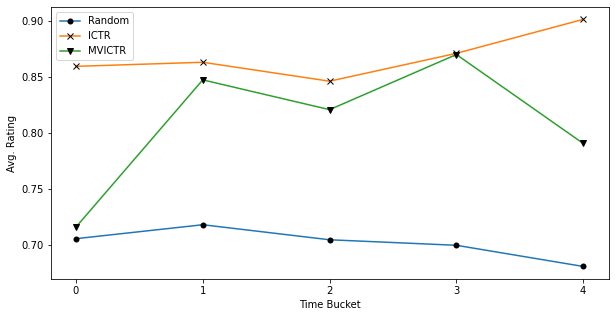

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(avg_rating_rand, marker='.', markeredgecolor='black', markeredgewidth=3)
ax.plot(avg_rating, marker='x', markerfacecolor='black', markeredgecolor='black')
ax.plot(avg_rating_mvictr, marker='v', markerfacecolor='black',  markeredgecolor='black')

ax.set_xticks(np.arange(T))

# label axes
plt.xlabel('Time Bucket')
plt.ylabel('Avg. Rating')
plt.legend(['Random', 'ICTR', 'MVICTR'])
plt.show()

Becuase we do not have many data points there will be siginifcant variability from run to run. Becuase of this, we run replayer multiple times over the same model in a boostrap experiment.

In [35]:
def run_boostrap_experiment(n_iter, model):
    """
    ;param: number of iterations to run
    ;param: model
    """
    results = []
    for _ in range(n_iter):
        # run experiment
        replayer = Replayer(model, time_buckets=T)
        replayer.replay(ratings)
        # get results
        avg_rating, impressions = model.get_results()
        results.append(avg_rating[0])
        
    return results

In [34]:
# get ratings data
ratings = pd.read_csv('data/ml-100k/ratings_enc.csv')                   # get data
ratings = ratings[['user_id', 'item_id', 'rating', 'time_bucket']]      # one time bucket
ratings['time_bucket'] = 0

# one time bucket
T = 1

###################### Random ######################
random = Random(
    n_users=n_users, 
    n_items=n_items, 
    time_buckets=T)

###################### ICTR ########################
B = 10                                                      # number of particles
K = 3                                                       # latent parameter dimension
ictr = ICTR(                                                # initialize model
    n_users=n_users, 
    n_items=n_items, 
    n_lat=K, 
    n_particles=B, 
    time_buckets=T)

###################### MVICTR ######################
gamma = 100
user_offset = gamma * match.get_theta(view=0).T
item_offset = gamma * match.get_theta(view=1).T

B = 10                                                      # number of particles
K = 3                                                       # latent parameter dimension
mvictr = ICTR(                                              # initialize model
    n_users=n_users, 
    n_items=n_items, 
    n_lat=K, 
    n_particles=B, 
    time_buckets=T)

###################### Run Experiment ###############
models = [random, ictr, mvictr]
results = []
n_iter = 10
for model in models:
    results.append(run_boostrap_experiment(n_iter, model))

In [28]:
results[2]

[[0.7007168458781363], [0.7007168458781363]]

In [1]:
# random guessing as baseline
from Random import Random

# instantiate model instance
model = Random(
    n_users=n_users, 
    n_items=n_items, 
    time_buckets=1)

results = []
for _ in range(2):
    # run experiment
    replayer = Replayer(model, time_buckets=T)
    replayer.replay(ratings)

    # get results
    avg_rating_rand, impressions_rand = replayer.get_results()
    reward_trace_rand, arm_trace_rand = replater.get_trace()

    results.append(avg_rating_rand)

results

NameError: name 'n_users' is not defined

In [33]:
run_boostrap_experiment(n_iter=2, model=random)

[[0.717607973421927], [0.717607973421927]]

# Book Recommender

In [ ]:
# user profile data
user = pd.read_csv('data/books/users.csv')#.drop('Unnamed: 0', axis=1)

# encode
encoder = LabelEncoder()
for col in user.columns:
    user['{}'.format(col) + '_enc'] = encoder.fit_transform(user['{}'.format(col)])
    # print(user['{}'.format(col)].nunique() == user['{}'.format(col)].max() + 1)

# rename ID column
user.rename(columns={'User-ID':'user_id'}, inplace=True)

# save encoded version
# user.to_csv('data/books/users_enc.csv', index=False)
user.head()

In [ ]:
# item profile data
item = pd.read_csv('data/books/books.csv', low_memory=False)
item = item[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

# encode
encoder = LabelEncoder()
for col in item.columns:
    # mode = item['{}'.format(col)].mode()
    item['{}'.format(col)] = encoder.fit_transform(item['{}'.format(col)].astype(str))
    # did it work?
    print(item['{}'.format(col)].nunique() == item['{}'.format(col)].max() + 1)

# rename ID column
item.rename(columns={'ISBN':'item_id'}, inplace=True)

# save
item.to_csv('data/books/books_enc.csv', index=False)
item.head()

In [ ]:
# book recommender
rating = pd.read_csv('data/books/ratings_enc.csv').drop('Unnamed: 0', axis=1)
ratings.head()

# Books: Bayesian Clustering 

In [2]:
user = pd.read_csv('data/books/users_enc.csv')
item = pd.read_csv('data/books/books_enc.csv')
rating = pd.read_csv('data/books/ratings_enc.csv')

In [54]:
# create synthetic data
from scipy import stats

# three clusters
n_clusters = 5
alpha = np.ones(n_clusters)
seeds = [1, 2]
theta_u, theta_v = [stats.dirichlet(alpha, seed=seeds[i]).rvs() for i in range(2)]

vocab_sizes = [10, 12, 13, 5, 7]
n_vocabs = len(vocab_sizes)

# sample distriubtion over ontology vocabs within clusters
seeds = np.arange(n_vocabs)
beta_u = [np.ones(vocab_sizes[i]) for i in range(n_vocabs)]
phi_u = [stats.dirichlet(beta_u[i], seed=seeds[i]).rvs(size=n_clusters) for i in range(n_vocabs)]

# phi[i] shape is n_clusters, vocab_sizes[i]
# sample cluster assignments
k_u = stats.multinomial(1, theta_u[0]).rvs().argmax()
k_v = stats.multinomial(1, theta_v[0]).rvs().argmax()

# sample features from phi 
phi_u[k_u]


array([[8.93657286e-02, 2.11011675e-01, 1.89430372e-05, 5.96227837e-02,
        2.62843684e-02, 1.60452263e-02, 3.41352580e-02, 7.02160069e-02,
        8.37094997e-02, 1.28177782e-01, 8.99840502e-02, 1.91428679e-01],
       [1.93513582e-02, 1.78069108e-01, 2.34946485e-03, 9.39189756e-02,
        4.56947093e-02, 6.92079727e-02, 1.27985312e-02, 1.86786438e-02,
        1.36482968e-01, 2.91908430e-01, 3.18149601e-02, 9.97248780e-02],
       [1.62111493e-01, 1.74474770e-01, 6.89193384e-03, 3.08912536e-03,
        1.44326045e-02, 1.63219265e-01, 8.02760581e-03, 4.23876860e-02,
        2.45612417e-01, 5.90702635e-02, 9.12873218e-02, 2.93955138e-02],
       [7.44972656e-02, 1.15573999e-01, 1.18542037e-03, 8.90705333e-02,
        2.88835547e-01, 8.85639326e-02, 2.11374804e-02, 1.00011106e-01,
        6.99730141e-03, 3.81500126e-02, 1.53653527e-01, 2.23238751e-02],
       [5.64000818e-02, 2.31500493e-02, 3.25025848e-03, 1.88764045e-01,
        3.95186226e-02, 5.12924141e-02, 1.12419609e-01, 9.11

In [3]:
from BayesMatch import BayesMatch

n = 1000
n_clusters = 2
match = BayesMatch(
        u_data=user.drop('user_id', axis=1).head(n),
        v_data=item.drop('item_id', axis=1).head(n),
        n_common=0,
        n_clusters=n_clusters,
        burn_in=0,
        n_samples=10,
        eval_every=100
    )

match.fit()

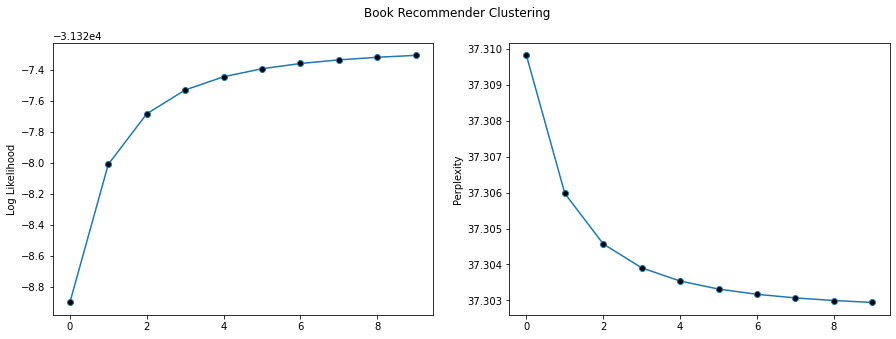

In [4]:
# plot results
burn_in = match.burn_in

# figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot data
ax[0].plot(match.log_likelihood_trace[burn_in:], marker='o', markerfacecolor='black')
ax[1].plot(match.perplexity_trace[burn_in:], marker='o', markerfacecolor='black')

# labels
plt.suptitle('Book Recommender Clustering')
ax[0].set_ylabel('Log Likelihood')
ax[1].set_ylabel('Perplexity')

# show
plt.show()

Plot Parameter Traces

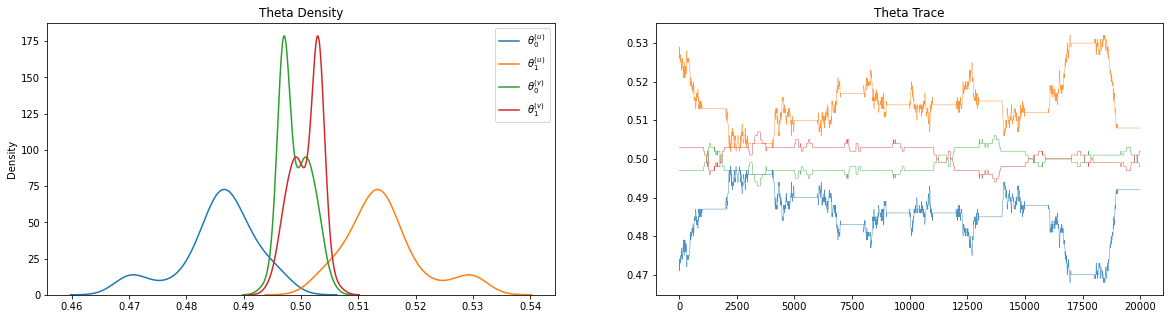

In [5]:
# make figure
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# plot user, item theta
burn_in = match.burn_in
u_theta = [x/sum(x) for x in match.u_theta_trace]
v_theta = [x/sum(x) for x in match.v_theta_trace]

for i, trace in enumerate([u_theta, v_theta]):
    for i in range(n_clusters):
        theta_norm = [x[i] for x in trace[burn_in:]]
        sns.kdeplot(theta_norm, bw_adjust=3, ax=ax[0])

    ax[0].set_title('Theta Density')

    ax[1].plot(trace, lw=0.5, alpha=0.8)
    ax[1].set_title('Theta Trace')

# add legend
legend = []
t = ['{(u)}', '{(v)}']
for l in t:
    legend += ['$\\theta_{}^{}$'.format(i, l) for i in range(n_clusters)]
ax[0].legend(legend)

plt.show()

In [8]:
# analyze phi
def n_timesteps(x):
    """
    ;param x: feature id
    Return: number of timesteps for feature x
    """
    return len(match.phi_u_trace[x])

# cluster_id x ontology_id
def get_phi(x, t):
    # x: feature id
    # k: cluster id
    # t: timestep
    return match.phi_u_trace[x][t]#[k, :]

def get_phi_norm(x, t):
    """
    ;param x: feature id
    ;param t: timestep
    return: normalized phi
    """
    return get_phi(x, t)/get_phi(x, t).sum(axis=0)

def get_trace(x, v, k):
    """
    ;param x: feature id
    ;param v: value of feature x
    ;param k: cluster id
    return: trace for feature x=v in k
    """
    return [get_phi_norm(x, t)[:, v] for t in range(n_timesteps(x))]

def plot_trace(x, v, k, ax):
    """
    makes trace plot
    ;param x: feature id
    ;param v: value of feature x
    ;param k: cluster id
    ;param fig: matplotlib figure
    """
    trace = get_trace(x, v, k)
    sns.kdeplot([trace[i][k] for i in range(len(trace))], bw_adjust=3, warn_singular=False, ax=ax[0])
    ax[1].plot(trace)

def get_legend():
    return ['Cluster {}'.format(i) for i in range(match.n_clusters)]

def build_figure(x, v, ax):
    # make figure
    for k in range(match.n_clusters):
        plot_trace(x, v, k, ax)
    # add labels
    ax[0].set_title('$\Phi_k$ Density, $x$ = {}, $\\nu$ = {}'.format(k, v))
    ax[0].legend(get_legend())
    plt.show()

def plot_feature_trace(x):
    """
    build and stack plots for onotology of feature x for each cluster
    ;param x: feature id
    """
    d = match.v_users[x]
    fig, ax = plt.subplots(1, 2, figsize=(20, 2.5))
    for v in range(d):
        build_figure(x, v, ax)

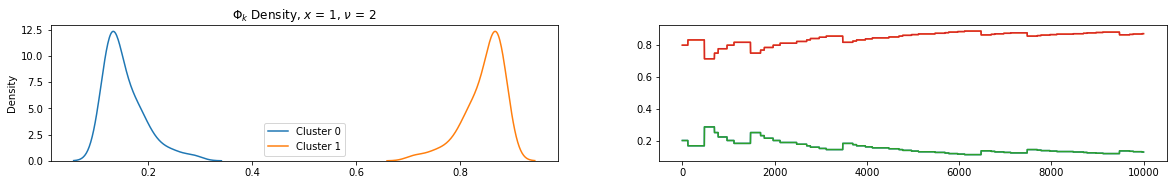

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 2.5))
build_figure(1, 2, ax)

In [7]:
def credible_int(x, v, k):
    trace = get_trace(x, v, k)
    trace_k = [trace[i][k] for i in range(len(trace))]
    
    # compute upper, lower, mean credible interval
    lower = np.quantile(trace_k, q=0.2)
    upper = np.quantile(trace_k, q=0.8)
    m = np.mean(trace_k)
    return lower, upper, m

# create data frame for every cluster
def build_dataframe(x, k):
    # get vocab size
    vocab_size = match.v_users[x]
    # create empty array
    results = np.empty([vocab_size, 3])
    for v in range(vocab_size):
        results[v] = credible_int(x, v, k)

    return pd.DataFrame(results, columns=['0.2', '0.8', 'mean'])

In [47]:
credible_int(x, v, k)

(0.1249804522565915, 0.18182645079134074, 0.15433818158185794)

In [94]:
results = build_dataframe(0, 0)

Text(0.5, 1.0, 'Cluster 0')

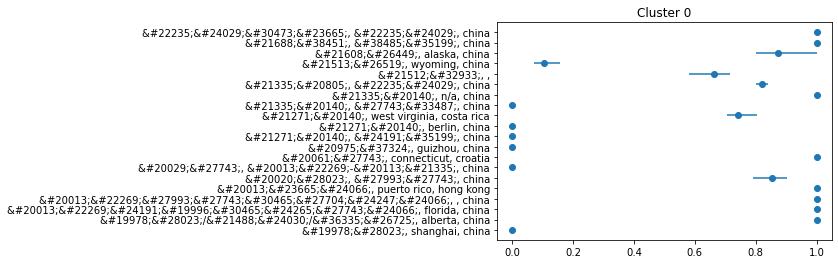

In [99]:
results_ = pd.DataFrame(results, columns=['0.2', '0.8', 'mean'])#.sort_values('mean', ascending=False)
results_ = results_.merge(user[['Location_enc', 'Location']], left_on=results_.index, right_on='Location_enc').drop('Location_enc', axis=1)

b = 20
plt.scatter(results_['mean'].head(b), results_['Location'].head(b))
plt.hlines(np.arange(b), results_['0.2'].head(b), results_['0.8'].head(b))

plt.title('Cluster {}'.format(k))

In [46]:
item.nunique()

item_id                271360
Book-Title             242135
Book-Author            102024
Year-Of-Publication       118
Publisher               16808
dtype: int64

In [49]:
len(user)

278858

In [5]:
sum(3 * [])

0